<a href="https://colab.research.google.com/github/ykato27/Image-Classification/blob/main/3_5_1_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 畳み込みニューラルネットワークの実装 
# Implementation of convolutional neural networks






#### 最適化法のクラスの読み込み Loading a class of optimization methods

これまでと同じです．下のコードが隠されたセルも実行してください．

「コードを表示」を選んで1行目の ` #@title` を消去するとコードの全体が表示されます．

The same as before. Run the cell with the hidden code below.

Select "Show Code" and delete the ` #@title` in the first line to show the whole code.

In [1]:
#@title
class SGD:
  def __init__(self, learning_rate = 0.01):
    self.lr = learning_rate

  def update(self, params, grads):
    for key in params:
      params[key] -= self.lr * grads[key] 

class Momentum:
  def __init__(self, learning_rate = 0.01, alpha = 0.5):
    '''
    self.lr = learning_rate : 学習係数
    self.alpha = alpha      : alpha
    '''
    self.lr = learning_rate
    self.alpha = alpha
    self.v = None 

  def update(self, params, grads):
    '''
    params : 更新するパラメータ
    grads  : 目的関数のパラメータに関する勾配
    self.v : モメンタム，パラメータと同じ形式

    '''
    # self.v の初期化
    if self.v is None:
      self.v = {}
      for key in params:
        self.v[key] = np.zeros_like(params[key])
    
    # モメンタムとパラメータの更新
    for key in params:
      self.v[key] = self.alpha * self.v[key] - self.lr * grads[key] 
      params[key] += self.v[key]

class Adam:
  def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999):
    self.learning_rate = learning_rate
    self.beta1 = beta1
    self.beta2 = beta2
    self.iter = 0
    self.m = None
    self.v = None
    
  def update(self, params, grads):
    if self.m is None:
      self.m, self.v = {}, {}
      for key in params:
        self.m[key] = np.zeros_like(params[key])
        self.v[key] = np.zeros_like(params[key])

    self.iter += 1
    lr_t  = self.learning_rate * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
      
    for key in params.keys():
      self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
      self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
      params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

class AdaGrad:
  def __init__(self, learning_rate = 0.01):
    self.learning_rate = learning_rate
    self.h = None
      
  def update(self, params, grads):
    if self.h is None:
      self.h = {}
      for key in params:
        self.h[key] = np.zeros_like(params[key])
        
    for key in params:
      self.h[key] += grads[key] * grads[key]
      params[key] -= self.learning_rate * grads[key] / (np.sqrt(self.h[key]) + 1e-7)  

#### 既存の層の高階化対応 Support for higher order of existing layers

アファイン変換層は入力が4階の配列の場合，出力が2階の配列になるように書き換えます．バッチ正規化層は入力が4階の場合，出力も4階になるように書き換えます．シグモイド層，ReLU層，ドロップアウト層はそのままで4階の場合にも対応できます．ソフトマックス層の入力は常に2階のもののみです．


The affine transformation layer is rewritten so that when the input is a 4-level array, the output is a 2-level array. Batch normalization layer is rewritten so that when the input is a fourth-order array, the output is also a fourth-order array. The sigmoid, ReLU, and dropout layers can be rewritten to handle the fourth-order case. The softmax layer always accepts only second-order inputs.


In [2]:
def softmax(a):   
  # a がベクトルのとき
  if a.ndim == 1:
    c = np.max(a)#オーバーフロー対策1
    x = a-c
    x = 709*(x >= 709) + x*(x<709)#オーバーフロー対策2
    exp_x = np.exp(x)
    sum_exp_x = np.sum(exp_x)
    return exp_x/sum_exp_x
    
  # a が２階の配列のとき
  a = a.T
  c = np.max(a, axis=0) #オーバーフロー対策1
  x = a - c
  x = 709*(x >= 709) + x*(x<709) #オーバーフロー対策2
  exp_x = np.exp(x)
  sum_exp_x = np.sum(exp_x, axis=0)
  return (exp_x/sum_exp_x).T

def sigmoid(x):
  x = -709*(x <= -709)+709*(x >= 709) + x*(x>-709) *(x<709) #オーバーフロー対策
  return 1/(1+np.exp(-x))


class Affine:
  def __init__(self, W, b):
    self.W = W
    self.b = b
    self.x = None
    self.dW = None
    self.db = None
    self.xshpe = None
    
  def forward(self, x):
    #2階の配列に直す
    self.xshape = x.shape
    x = x.reshape(self.xshape[0],-1)
    
    self.x = x
    out = np.dot(self.x, self.W) +self.b
    return out
  
  def backward(self,dout):
    self.dW = np.dot(self.x.T, dout)
    self.db = np.sum(dout, axis=0)
    dx = np.dot(dout, self.W.T)
    
    #元の形に戻す
    dx = dx.reshape(*self.xshape)# *はカッコを外す 
    return dx
  
class Relu:       ####Relu層の定義
  def __init__(self):
    self.mask = None
    
  def forward(self, x):
    self.mask = (x > 0)  # x> 0 ならTrue , x<= 0 ならFalse
    out = x * self.mask  # x> 0 なら x * 1  , x<= 0 なら x * 0
    return out
  
  def backward(self,dout):
    dx = dout * self.mask
    return dx

class Sigmoid:
  def __init__(self):
    self.y = None

  def forward(self, x):
    self.y = sigmoid(x)
    return self.y
  
  def backward(self,dout):
    dx = dout*(1-self.y)*self.y
    return dx

  
class SoftmaxWithLoss:
  def __self__(self):
    self.loss = None
    self.y = None
    self.t = None
    
  def forward(self, x, t):
    y = softmax(x)
    self.y = y
    self.t = t
    batch_size = y.shape[0]
    return -np.sum(t*np.log(y+1e-7))/batch_size   # 1e-7 = 10^(-7)はlogの中に0を入力するのを防止するため
  
  def backward(self):
    batch_size = self.y.shape[0]
    dx = (self.y-self.t)/batch_size
    return dx
  
class BatchNormalization:
  def __init__(self, gamma = 1, beta = 0, momentum=0.9, running_mean=None, running_var=None):    
    self.beta = beta
    self.gamma = gamma
    self.momentum = momentum
    
    # テスト時に使用する平均と分散
    self.running_mean = running_mean
    self.running_var = running_var
   
    self.std = None
    self.xc = None
    self.y = None
    self.xshape = None
  
  def forward(self, x, train_flag = True):
    
    #2階の配列に直す
    self.xshape = x.shape
    x = x.reshape(self.xshape[0], -1)
    
    
    if self.running_mean is None:
      D = x.shape[1]
      self.running_mean = np.zeros(D)
      self.running_var = np.zeros(D)
    
    if train_flag:
      mu = np.mean(x, axis=0)  #バッチについての平均．
      var = np.mean((x-mu)**2, axis=0) 
      std = np.sqrt(var+10e-7)     
      xc = (x-mu)/std    
      y = self.gamma * xc + self.beta
      
      self.std = std
      self.xc = xc
      
      self.running_mean = self.momentum * self.running_mean + (1-self.momentum) * mu
      self.running_var = self.momentum * self.running_var + (1-self.momentum) * var  
      
    else:
      xc = (x - self.running_mean) / (np.sqrt(self.running_var + 10e-7)) 
      y = self.gamma * xc + self.beta
      
    #yをxの元の形と同じ形にする
    y = y.reshape(*self.xshape)
    return y      
  
  def backward(self, dout):
    #2階の配列に直す
    dout = dout.reshape(self.xshape[0], -1)
    
    
    self.dbeta = dout.sum(axis = 0) 
    self.dgamma = (self.xc * dout).sum(axis = 0)
    c = np.mean(dout, axis=0)
    d = np.mean(self.xc * dout, axis =0)
    dx = dout - c - self.xc * d
    dx *= self.gamma/self.std
    
    #dxをxの元の形と同じ形にする
    dx = dx.reshape(*self.xshape)
    return dx

class Dropout:
  def __init__(self, dropout_ratio = 0.5):
    self.dropout_ratio = dropout_ratio
    self.mask = None
  
  def forward(self, x, train_flag = True):
    if train_flag:
      self.mask = np.random.rand(*x.shape) > self.dropout_ratio
      return x * self.mask
    else:
      return x * (1.0 - self.dropout_ratio)
  
  def backward(self, dout):
    return dout * self.mask
    

畳み込み層とプーリング層の読み込み

Loading convolution and pooling layers

In [3]:
class Convolution:
  def __init__(self, F, b, stride=1, pad=0):
    self.F = F
    self.b = b
    self.stride = stride
    self.pad = pad
        
    #中間データ（backward時に使用）
    self.xshape = None   
    self.xh = None
    self.f_col = None
        
    # 勾配
    self.dF = None
    self.db = None

  def forward(self, x):
    OC, C, FH, FW = self.F.shape
    N, C, H, W = x.shape
    pad = self.pad
    stride = self.stride
    
    #出力サイズ
    OH = (H + 2 * pad - FH)//stride +1
    OW = (W + 2 * pad - FW)//stride +1
    
    # xh, xt, xcol の順に計算
    x_pad = np.pad(x, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')# (N,C,H,W)のうち最後の2つの方向に関してパディングする 
    xh = np.zeros((N, C, FH, FW, OH, OW))
    for fh in range(FH):
      for fw in range(FW):
        xh[:,:,fh,fw,:,:] =x_pad[:,:,fh:fh + OH * stride:stride, fw: fw + OW * stride:stride] 
    xt = xh.transpose(0,4,5,1,2,3) # (N, OH, OW, C, FH, FW)
    xcol = xt.reshape(N,OH,OW,-1)  # (N, OH, OW,  C * FH * FW)
    
    #出力 y を計算
    fcol = self.F.reshape(OC,-1).T # (C * FH * FW, OC)
    y = (np.dot(xcol,fcol) + self.b).transpose(0,3,1,2)  #  (N, OH, OW, OC).transpose(0,3,1,2) = (N, OC, OH, OW)
    
    #クラス変数として格納
    self.xshape = x.shape   
    self.xh = xh
    self.fcol = fcol
     
    return y
    
  def backward(self,dout):
    OC, C, FH, FW = self.F.shape
    N, OC, OH, OW = dout.shape
    N, C, H, W = self.xshape
    stride = self.stride
    pad = self.pad
    
    # db と dF を計算
    xh_col = self.xh.transpose(1,2,3,0,4,5).reshape(C,FH,FW,-1) # (C, FH, FW, N, OH, OW).reshape(C,FH,FW,-1) = (C, FH, FW, N * OH * OW)
    dout_col = dout.transpose(1,0,2,3).reshape(OC,-1) # (OC, N * OH * OW)
    self.db = dout_col.sum(axis = 1) # (OC,)
    self.dF = np.dot(dout_col, xh_col.transpose(0,1,3,2)) # (OC, N * OH * OW)(C, FH, N * OH * OW,  FW) = (OC, C, FH, FW)
    
    # dout と F から dxt を計算
    dxt = np.dot(dout.transpose(0,2,3,1), self.F.transpose(1,2,0,3))# (N, OH, OW, OC)( C, FH, OC, FW) = (N, OH, OW, C, FH, FW)
    dxt = dxt.transpose(0,3,1,2,4,5) #(N, OH, OW, C, FH, FW)
        
    #  dxt から dx を計算
    dx = np.zeros((N, C, H+ 2*pad + stride - 1, W+ 2*pad + stride - 1), dtype=np.float)  
    for fh in range(FH):
      for fw in range(FW):
        dx[:,:,fh:fh + OH * stride: stride, fw: fw + OW * stride: stride] += dxt[:,:,:, :,fh,fw]
    
    return dx[:, :, pad:H+pad, pad:W+pad] 
      
class Pooling:
  def __init__(self, S):
    self.S = S
        
    #中間データ（backward時に使用）
    self.xshape = None   
    self.argmax = None
 
  def forward(self, x):
    N, C, H, W = x.shape
    S = self.S
    FH, FW = S, S #本来は必要ないがコードを書く際に混乱するので導入
    stride = S
    self.xshape = x.shape
    
    #出力サイズ
    OH = H//S
    OW = W//S
    
    # xh, xt, xcol の順に計算    
    xh = np.zeros((N, C, FH, FW, OH, OW))
    for fh in range(FH):
      for fw in range(FW):
        xh[:,:,fh,fw,:,:] =x[:,:,fh:fh + OH * stride:stride, fw: fw + OW * stride:stride] 
    xt = xh.transpose(0,1,4,5,2,3) # (N, C, OH, OW, FH, FW)
    xcol = xt.reshape(N, C, OH,OW, -1)  # (N, C, OH, OW,  FH * FW)
    
    #argmaxを格納
    self.argmax = xcol.argmax(axis = -1).flatten()
 
   
    #出力 y を計算
    y = xcol.max(axis = 4)  # (N, C, OH, OW)
    return y
    
  def backward(self,dout):
    N, C, OH, OW = dout.shape
    N, C, H, W = self.xshape
    S = self.S
    FH, FW = S, S #本来は必要ないがコードを書く際に混乱するので導入
    stride = S
   
    # dout と　self.argmax から dxt を計算
    dxt = np.zeros((N * C * OH * OW, FH * FW))
    dxt[np.arange(N * C * OH * OW), self.argmax] = dout.flatten() # (N * C * OH *OW, FH*FW) =  (N * C * OH * OW)
    dxt = dxt.reshape(N, C, OH, OW, FH, FW) 
        
    #  dxt から dx を計算
    dx = np.zeros((N, C, H+ stride - 1, W+ stride - 1), dtype=np.float)  
    for fh in range(FH):
      for fw in range(FW):
        dx[:,:,fh:fh + OH * stride: stride, fw: fw + OW * stride: stride] += dxt[:,:,:, :,fh,fw]
    
    return dx[:, :, :H, :W]  
      

#### ネットワーククラス Network Class

新しいネットワークのクラスである` CNN` では前章の `MultiLayerNet`　に  `convolution()` というメソッドを追加して，`self.conlolution()` を実行するたびに畳み込み層が追加できるようにします．

コンストラクタのパラメータ：

*   `weight_decay_lambda`：ウェイト減衰法（$W_i$の大きさを減衰させる）のパラメータ（デフォルトは 0.0）

affine() のパラメータ：

*   `size`：層のサイズ （デフォルトは `None`）
*   `activation`：`'relu'` か `'sigmoid'` か `None`  
*   `batchnorm = False`：活性化関数の前にバッチ正規化するかどうか．

dropout() のパラメータ：

*   `dropout_ratio = 0.5`：ドロップアウトでマスクされる確率（デフォルトは 0.5）

convolution() のパラメータ：

*  `OC, FH, FW`：フィルターの出力チャンネル数，高さ，幅
* `stride=1, pad=0`：ストライド，パディングの幅
*   `batchnorm = False`：活性化関数の前にバッチ正規化するかどうか．
*   `activation = None`：`'relu'` か `'sigmoid'`（デフォルトは `None`）
*  `S=1`：プーリングの正方形のフィルターのサイズ．`S=1` のときはプーリングは行わない．

畳み込み層における細かく分けた層の順番は Convolution -- BatchNormalization -- Activation -- Pooling の順

For our new network class `CNN`, we will add a method `convolution()` to `MultiLayerNet` from the previous chapter so that we can add a convolution layer each time we run `self.convolution()`.

Constructor parameters:.

* `weight_decay_lambda`: parameter for weight decay method (to decay the size of $W_i$) (default is 0.0)

Parameters for affine():

* `size`: size of the layer (default is `None`)
* `activation`: `'relu'` or `'sigmoid'` or `None`.  
* `batchnorm = False`: whether to batch normalize before the activation function.

Parameters for dropout():.

* `dropout_ratio = 0.5`: probability of being masked by dropout (default is 0.5).

Parameters for convolution(): 

* `OC, FH, FW`: number of output channels, height and width of the filter.
* `stride=1, pad=0`: stride, width of padding.
* `batchnorm = False`: whether to batch normalize before the activation function.
* `activation = None`: `'relu'` or `'sigmoid'` (default is `None`)
* `S=1`: Size of the pooling square filter. If `S=1`, no pooling is done.

The order of the layers in the convolutional layer is Convolution -- BatchNormalization -- Activation -- Pooling


In [4]:
import numpy as np
from collections import OrderedDict

class CNN:
  '''
    コンストラクタの引数
    input_size          : 入力データ一つの次元
    weight_decay_lambda : L2正則化の係数

    クラス変数
    self.layers      : 層を格納する順序付き辞書
                       活性化関数も独立した層として扱う
    self.params      : 重みパラメータを格納する辞書
                       W1,W2 などと番号が付くのはAffine層の重みのみ 
    '''
  def __init__(self, input_dim = (1,28,28),  weight_decay_lambda = 0.0):
    self.all_dim_list = [input_dim] #各層を流れるデータの形を格納
    self.params = {}
    self.weight_decay_lambda = weight_decay_lambda
    self.layers = OrderedDict()
    self.batchnorm_flag = [False]
    self.lastLayer = SoftmaxWithLoss()
    self.idx = 0
    
  #層の追加  
  '''
  affine 層を付け加える場合は，
  self.affine(size = 100, activation = 'relu', batchnorm = True) 
  とすると，層のサイズ100，活性化関数ReLU, バッチ正規化ありになる
  self.affine(100, activation = 'sigmoid')
  とすると，層のサイズ100，活性化関数Sigmoid, バッチ正規化なし
    
  dropout 層を付け加える場合は
  self.dropout(dropout_ratio = 0.6)
  とするとマスクされる確率が0.6
  self.dropout()
  とするとマスクされる確率が0.5
  
  畳み込み層の追加： 
  convolution(self, OC＝10, FH=3, FW=3, stride = 1, pad = 0, S = 2, activation = 'relu', batchnorm = False)
  とすると stride = 1，pad = 0，プーリングのサイズ2，活性化ReLU，バッチ正規化なし
  convolution(self, OC＝10, FH=3, FW=3)
  とすると stride = 1，pad = 0，S = 1 つまりプーリングなし，活性化なし，バッチ正規化なし
  '''
  
  #アファイン層を追加するメソッド
  def affine(self, size, activation='relu',  batchnorm = False):
    self.idx += 1
    idx = self.idx    
    self.all_dim_list.append(size)
    
    # Heの初期値によるパラメータの初期化
    scale = np.sqrt(2.0 / np.prod(self.all_dim_list[idx - 1]))
    self.params['W' + str(idx)] = scale * np.random.randn(np.prod(self.all_dim_list[idx-1]), size)
    self.params['b' + str(idx)] = np.zeros(size)
    
    #アファイン層の追加
    self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)], self.params['b' + str(idx)])
    
    #バッチ正規化層の追加
    if batchnorm:
      self.batchnorm_flag.append(True)
      self.params['gamma' + str(idx)] = np.ones(size)
      self.params['beta' + str(idx)] = np.zeros(size)
      self.layers['BatchNorm' + str(idx)] = BatchNormalization(self.params['gamma' + str(idx)], 
                                                                       self.params['beta' + str(idx)])
    else:
      self.batchnorm_flag.append(False)
    
    #活性化層の追加
    if activation == 'relu':
      self.layers['Relu' + str(idx)] = Relu()
    if activation == 'sigmoid':
      self.layers['Sigmoid' + str(idx)] = Sigmoid()
  
  #ドロップアウト層をの追加するメソッド    
  def dropout(self, dropout_ratio = 0.5):
    self.layers['Dropout' + str(self.idx)] = Dropout(dropout_ratio)      
  
  #畳み込み層を追加するメソッド
  def convolution(self, OC, FH, FW, stride = 1, pad = 0, S = 2, activation=None, batchnorm = False):
    self.idx += 1
    idx = self.idx
    C, H, W =  self.all_dim_list[idx - 1]    
    
    #出力サイズ
    OH = (H + 2 * pad - FH)//stride +1 # //は切り捨て除算
    OW = (W + 2 * pad - FW)//stride +1
    
    # パラメータの初期化（Heの初期値）
    scale = np.sqrt(2.0 / (C*FH*FW))
    self.params['F' + str(idx)] = scale * np.random.randn(OC, C, FH, FW)
    self.params['b' + str(idx)] = np.zeros(OC)
    
    #畳み込み層の追加
    self.layers['Conv' + str(idx)] = Convolution(self.params['F' + str(idx)], self.params['b' + str(idx)], 
                                                        stride = stride, pad = pad)          
    #バッチ正規化層の追加
    if batchnorm:
      self.batchnorm_flag.append(True)
      self.params['gamma' + str(idx)] = np.ones(OC*OH*OW)
      self.params['beta' + str(idx)] = np.zeros(OC*OH*OW)
      self.layers['BatchNorm' + str(idx)] = BatchNormalization(self.params['gamma' + str(idx)], 
                                                                       self.params['beta' + str(idx)])
    else:
      self.batchnorm_flag.append(False)
    
    #活性化層の追加
    if activation == 'relu':
      self.layers['Relu' + str(idx)] = Relu()
    if activation == 'sigmoid':
      self.layers['Sigmoid' + str(idx)] = Sigmoid()
    
    #プーリング層の追加
    if S > 1:
      self.layers['Pooling' + str(idx)] = Pooling(S)
      OH = OH//S
      OW = OW//S
      
    #出力サイズの格納
    self.all_dim_list.append((OC,OH,OW))
    
  
  #順方向の計算 #Softmaxの手前まで
  def predict(self, x, train_flg=False):
    for key, layer in self.layers.items():
      if "Dropout" in key or "BatchNorm" in key:
        x = layer.forward(x, train_flg)
      else:
        x = layer.forward(x)
    return x
  
  #誤差の計算
  def loss(self,x,t, train_flg=False):
    x = self.predict(x, train_flg)
    return self.lastLayer.forward(x ,t)
  
  #精度（クラッシュ対策でバッチに分割して計算）
  def accuracy(self, x, t, batch_size=100):
    acc = 0.0
    for i in range(int(x.shape[0] / batch_size)):
      tx = x[i*batch_size:(i+1)*batch_size]
      tt = t[i*batch_size:(i+1)*batch_size]
      y = self.predict(tx, train_flg=False)
      y = np.argmax(y, axis=1)
      tt = np.argmax(tt, axis=1)
      acc += np.sum(y == tt)

    return acc / x.shape[0]
  
  #誤差逆伝搬法による勾配の計算
  def gradient(self,x,t):
    self.loss(x,t,train_flg = True)
    
    dout = self.lastLayer.backward()
    
    layers = list(self.layers.values())
    layers.reverse()
    for layer in layers:
      dout = layer.backward(dout)
    
    #出力辞書の生成
    grads = {}
    all_num = len(self.all_dim_list)
    
    for idx in range(1, all_num):
      #アファイン層か畳み込み層かで場合分けして勾配をgradsに追加
      if type(self.all_dim_list[idx]) == int:#アファインのときはデータの型は整数型
        grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW+ self.weight_decay_lambda * self.params['W' + str(idx)]
        grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db
      else:#アファインのときはデータの型はtuple
        grads['F' + str(idx)] = self.layers['Conv' + str(idx)].dF+ self.weight_decay_lambda * self.params['F' + str(idx)]
        grads['b' + str(idx)] = self.layers['Conv' + str(idx)].db
      
      #正規化層の勾配をgradsに追加
      if self.batchnorm_flag[idx]:
        grads['gamma' + str(idx)] = self.layers['BatchNorm' + str(idx)].dgamma
        grads['beta' + str(idx)] = self.layers['BatchNorm' + str(idx)].dbeta
    
    return grads



学習を行う関数の読み込み Loading the function for training

In [5]:
#@title
#学習用の関数
def training(network, x_train, t_train,  x_test, t_test, iters_num=10000,  batch_size=100):
  '''
  この関数を使う前に optimizer を与えておく必要がある
  例：
  optimizer = SGD(learning_rate = 0.01)
  '''
  network.train_accuracy_list =[] 
  network.test_accuracy_list =[] 
  train_size = x_train.shape[0]

  for i in range(iters_num):
    if i%int(iters_num/10) ==0:
      #精度の記録 
      choice = np.random.choice(len(x_train),len(x_test))
      x_train_part, t_train_part = x_train[choice], t_train[choice]
      train_accuracy = network.accuracy(x_train_part,t_train_part)
      test_accuracy = network.accuracy(x_test,t_test)
      network.train_accuracy_list.append(train_accuracy)
      network.test_accuracy_list.append(test_accuracy)
      print('iteration:', i, ' train_accuracy = ', train_accuracy,
            ' test_accuracy = ', test_accuracy)

    #ミニバッチを選ぶ  
    batch_mask = np.random.choice(train_size,batch_size, replace=False)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    #勾配を計算  
    grads = network.gradient(x_batch,t_batch)     

    # パラメータを更新 
    optimizer.update(network.params, grads)

  #精度の記録  
  choice = np.random.choice(len(x_test),len(x_test))
  x_train_part, t_train_part = x_train[choice], t_train[choice]
  train_accuracy = network.accuracy(x_train_part,t_train_part)
  test_accuracy = network.accuracy(x_test,t_test)
  network.train_accuracy_list.append(train_accuracy)
  network.test_accuracy_list.append(test_accuracy)
  print('iteration:', i, ' train_accuracy = ', train_accuracy,
        ' test_accuracy = ', test_accuracy)
      

### 7.3.2 MNISTデータセットで実験 Experimenting with the MNIST Dataset

それではCNNを動かして実験してみましょう．

MNISTデータセットの読み込みなどは前節と同じです．

Now let's run the experiment with a CNN.

Loading the MNIST dataset is the same as in the previous section.


In [6]:
#@title
train = np.loadtxt('/content/sample_data/mnist_train_small.csv',  # 読み込みたいファイルのパス\
                  dtype = 'int',  # 出力される配列の要素のデータ型\
                  delimiter= ',',    # ファイルの区切り文字 \
                  #skiprows= 0,      # 先頭の何行を無視するか（指定した行数までは読み込まない）\
                  #usecols=None  # 読み込みたい列番号 \
                 )
test = np.loadtxt('/content/sample_data/mnist_test.csv', \
                  dtype = 'int',  delimiter= ',')

入力データセットは $\mbox{(データ数)}\times 1\times 28\times 28$ と4階の配列に直します．入力データのチャンネル数は1です．

The input dataset is rewritten as a 4-level array as $\mbox{(number of data)}\times 1\times 28\times 28$. The number of input data channels is 1.

In [7]:
train_size = train.shape[0]
x_train = train.T[1:].T/float(255)
x_train = x_train.reshape(train_size,1,28,28)
t_train =  np.eye(10)[train.T[0]]
test_size = test.shape[0]
x_test = test.T[1:].T/float(255)
x_test = x_test.reshape(test_size,1,28,28)
t_test =  np.eye(10)[test.T[0]]

####  単純なCNN,  A simple CNN

```
入力 - conv - relu - pool - affine - relu - affine - softmax
```

という比較的簡単な CNN を定義してみましょう．

始めの畳み込み層のパラメータは，OC = 30, FH = 5, FW =5, S = 2 ととります．

Let's define a relatively simple CNN as above.

The parameters of the first convolutional layer are OC = 30, FH = 5, FW =5, S = 2.

In [8]:
network = CNN(input_dim=(1,28,28))
network.convolution(OC = 30, FH = 5, FW =5, S = 2, activation = 'relu')
network.affine(100)
network.affine(10, activation = None)

出来上がったネットワークの構造は `network.layers` および
`network.all_dim_list`  で見られます．

中間層のサイズが $30\times 12\times 12= 4320$ と大きいことが分かります．

The structure of the resulting network can be seen by 
network.layers` and `network.all_dim_list`.

The size of the middle layer is large as $30\times 12\times 12= 4320$.

In [9]:
print(network.all_dim_list)
network.layers

[(1, 28, 28), (30, 12, 12), 100, 10]


OrderedDict([('Conv1', <__main__.Convolution at 0x7ff793122fd0>),
             ('Relu1', <__main__.Relu at 0x7ff793122510>),
             ('Pooling1', <__main__.Pooling at 0x7ff793122650>),
             ('Affine2', <__main__.Affine at 0x7ff797867510>),
             ('Relu2', <__main__.Relu at 0x7ff797867850>),
             ('Affine3', <__main__.Affine at 0x7ff793122d90>)])

では実験開始です．iters_num=1000  （1000*100/20000 = 5回転 = 5エポック）としています．

           はたしてどうなるでしょうか

Let's start the experiment. We set iters_num=1000 (1000*100/20000 = 5 revolutions = 5 epochs).

iteration: 0  train_accuracy =  0.0507  test_accuracy =  0.049
iteration: 100  train_accuracy =  0.9416  test_accuracy =  0.9455
iteration: 200  train_accuracy =  0.965  test_accuracy =  0.959
iteration: 300  train_accuracy =  0.9737  test_accuracy =  0.9668
iteration: 400  train_accuracy =  0.9812  test_accuracy =  0.9737
iteration: 500  train_accuracy =  0.9867  test_accuracy =  0.9762
iteration: 600  train_accuracy =  0.9909  test_accuracy =  0.9782
iteration: 700  train_accuracy =  0.9916  test_accuracy =  0.9791
iteration: 800  train_accuracy =  0.992  test_accuracy =  0.9789
iteration: 900  train_accuracy =  0.9919  test_accuracy =  0.9799
iteration: 999  train_accuracy =  0.9923  test_accuracy =  0.9824


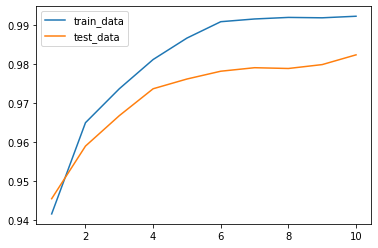

In [10]:
import matplotlib.pyplot as plt 

optimizer = Adam(learning_rate=0.001)
training(network, x_train, t_train, x_test, t_test, iters_num=1000, batch_size = 100)

#学習記録の表示
x = np.arange(0,len(network.train_accuracy_list),1) 

#グラフが見にくくなるので初期値は表示しない
plt.plot(x[1:], network.train_accuracy_list[1:], label = 'train_data')  
plt.plot(x[1:], network.test_accuracy_list[1:], label = 'test_data')  

plt.legend() #グラフの線の説明を表示